```
                            (#%(//***,.                                         
                          %@&&&&&&&&%&&&&&&#                                    
                       ,@@@@@&&%#(/*,,*(#%&&@&. ,#%&&&&&@&&#,                   
                      %&@@@@&&%(*,.....,*(#%&&@&&@@@@@&%&&@@@@@@@&              
                     /%@&@@@&%%(/******/(##%&&@@&@@&#((////(((#%&@@@@           
            /&@@@@@@&%@@@&@@&%%###(((#%%%&&&&&&&##%&#///*/(&@@@&%%&@@@#         
        (@@@@&/@@@@@@@@#%@@@@&&%%%%*/#&%#%&&&@@@@@@&#//&%                       
      @@@&&((##(%&@@@@@@&%@%@&@(%#%%%%%%,./(/.(/&((&@.                          
    &@@%//***,****(#%&@@@@@@@@%&*/#/.*(///*,//.#%%,&                            
   &@@(/**,,,,,,,,,,/&&@@@@@@@@&. ((/  /#%####%&&&(&                            
  &@@#(#%@@@&*        %@@@@@@@@&*#%&/%((((%&&%%&&@@&                            
 .@@@@@                   (#&&&&@@@@&&&//,,,(/(##/                             ,
 .@&                      %@@&&(%(,*(/,..*(#/(%#((#%(.                       ,.@
  .                   .(&%&@@@&%##**(#@/,  %@%%@#/#,%&&&                    ,.@@
                  *%&@@&(/#%&@&@@@#(.. .,,*/*&@@@///,%%&@%                 ,.@@@
                &@@@&&&%&@*,(#@@&@@@@@@(. ,&@&%@@&(,%,&&@@/              .,(@@@@
               &@@%%(/#%&@@,,*(%@%@@@@@@@&##/(%&&%&#/#&@@@&           ..*.@@@@@@
               @@@&%%%&&&@@@,%,&%&&&@@&%((&(%&@@@@%@#&&&&&@&.        ..*,@@@@@@@
               #@@@&%(((%&&@%#,(%%@@&@&%*@@@@@@@@@@@%@&&/(#&&*...  ...*,@@@@@@@@
               .%&&&(  ,(%&&@&*(&&&&&%/,&@&(@@&%&@@@&@@@&**#&&&,. ../*(@@@@@@@@&
         .......%&@@@&&&@@@@@&/&&&%%#/(&@&(%%@%%%%@&@&&@@&&./#%%* ./*&@@@@@@@@@@
##############(,*@@&&&&&&&@@@&&@@@@&#*#&&@&#%&%%#%%%@@&%@&&&#,(%&%*/@@@@@@@@@@@@
##############(*.@@@%%#&&&@@@&@&%#(*#&@&#(#&&%&&##(,%&&&%%&@&&&@%/&@@@@@@@@@@@@@
((##########(((/.%@@@#(#%&&@&&&%(*,(#%%&&(%#%#%&%#(,.#%&@@&@(,,%*#@@@@@@@@@@@@@@
//(##########(,...@@@@@&&%@@&&%#((#%&&&%&%%&%%%&&%    ##%&@@@@/*&%@@@@@@@@@@@@@@
(###########((/,,.(@@@&/,(@&&&&%%&&&&&%%&&&%%%%&&........%%%%**@@@@@@@@&@@@@@@@@
###(,,,,*/(((((*,(%@@@@@@@@&&&&&&&@&%/&&%#%%%%&&#./#(*//(((%*/@@@@@@@@@@@@@@@@@@
,*###(((((((((((#&&@@&@@@@&@@&&@@&&(&#**,**,,,********//((%*#@@@@@@@@@@@@@@@@@@@
///////////////(#%&&@@&@@@@@@@@@&(**,*,,,,,,,,,*%//%##(##(*&@@@@@@@@@@@@@@@@@@@@
///////////////////(##%&@@@@@@@&%******&/(##%###########/*@@@@@@@@@@@@@@@@@@@@@@
////////////////////((#%%%%&@@@&&#,(/#%*,*/*.&%########//@@@@@@@@@@@@@@@@@@@@@@&
%%(*/////////////////////(///////#@@@@@@@@/(%*,*/(.,&&*(@@@@@@@@@@@@@@@@@@@@@@(/
```
# Goblin Mode

In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import os
import torch
import cv2
import torch.nn as nn
import numpy as np
import mediapipe as mp
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output, Image
from models.fnn import PoseFFNN, get_accuracy, train
from helper import plot, get_pose_names, center_chest
from dataloader.dataloader import load_data, PoseLoader
from confusion_matrix import get_confusion_matrix, print_worst_cm

os.environ['MEDIAPIPE_BACKEND'] = 'gpu'

In [74]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
mediaPipe = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

In [79]:
# Get a list of all the pose names
poses = get_pose_names()

# Load the pose data by type
rawTrain, rawVal, rawTest = load_data(poses, type='raw')

# Data is loaded in batches and labels are one-hot encoded
train_data = PoseLoader(rawTrain, 'train', oneHot=True)
val_data = PoseLoader(rawVal, 'val', oneHot=True)
test_data = PoseLoader(rawTest, 'test', oneHot=True)

In [80]:
def go_nuts():

    # Define your model
    model = PoseFFNN(input_dim=69, output_dim=82)

    # Hyperparameters
    lr = 0.007
    L2_reg = 0.0005
    batch_size = 64

    # Set up your optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=L2_reg)

    # Set up your loss function
    criterion = nn.CrossEntropyLoss()

    epocs = 50
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model = train(model, train_loader, val_data, optimizer, criterion, epocs, batch_size)
    
    return model

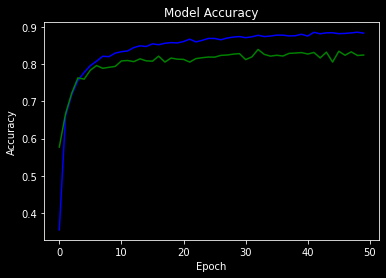

100%|██████████| 50/50 [03:04<00:00,  3.70s/it]

Epoch 50/50 | Training accuracy: 0.8832 | Validation accuracy: 0.8243


In [81]:
model = go_nuts()

In [82]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('val accuracy :', get_accuracy(model, val_data, device))
print('test accuracy :', get_accuracy(model, test_data, device))

val accuracy : 0.8392696797366058
test accuracy : 0.825233926954422


Confusion Matrix: 


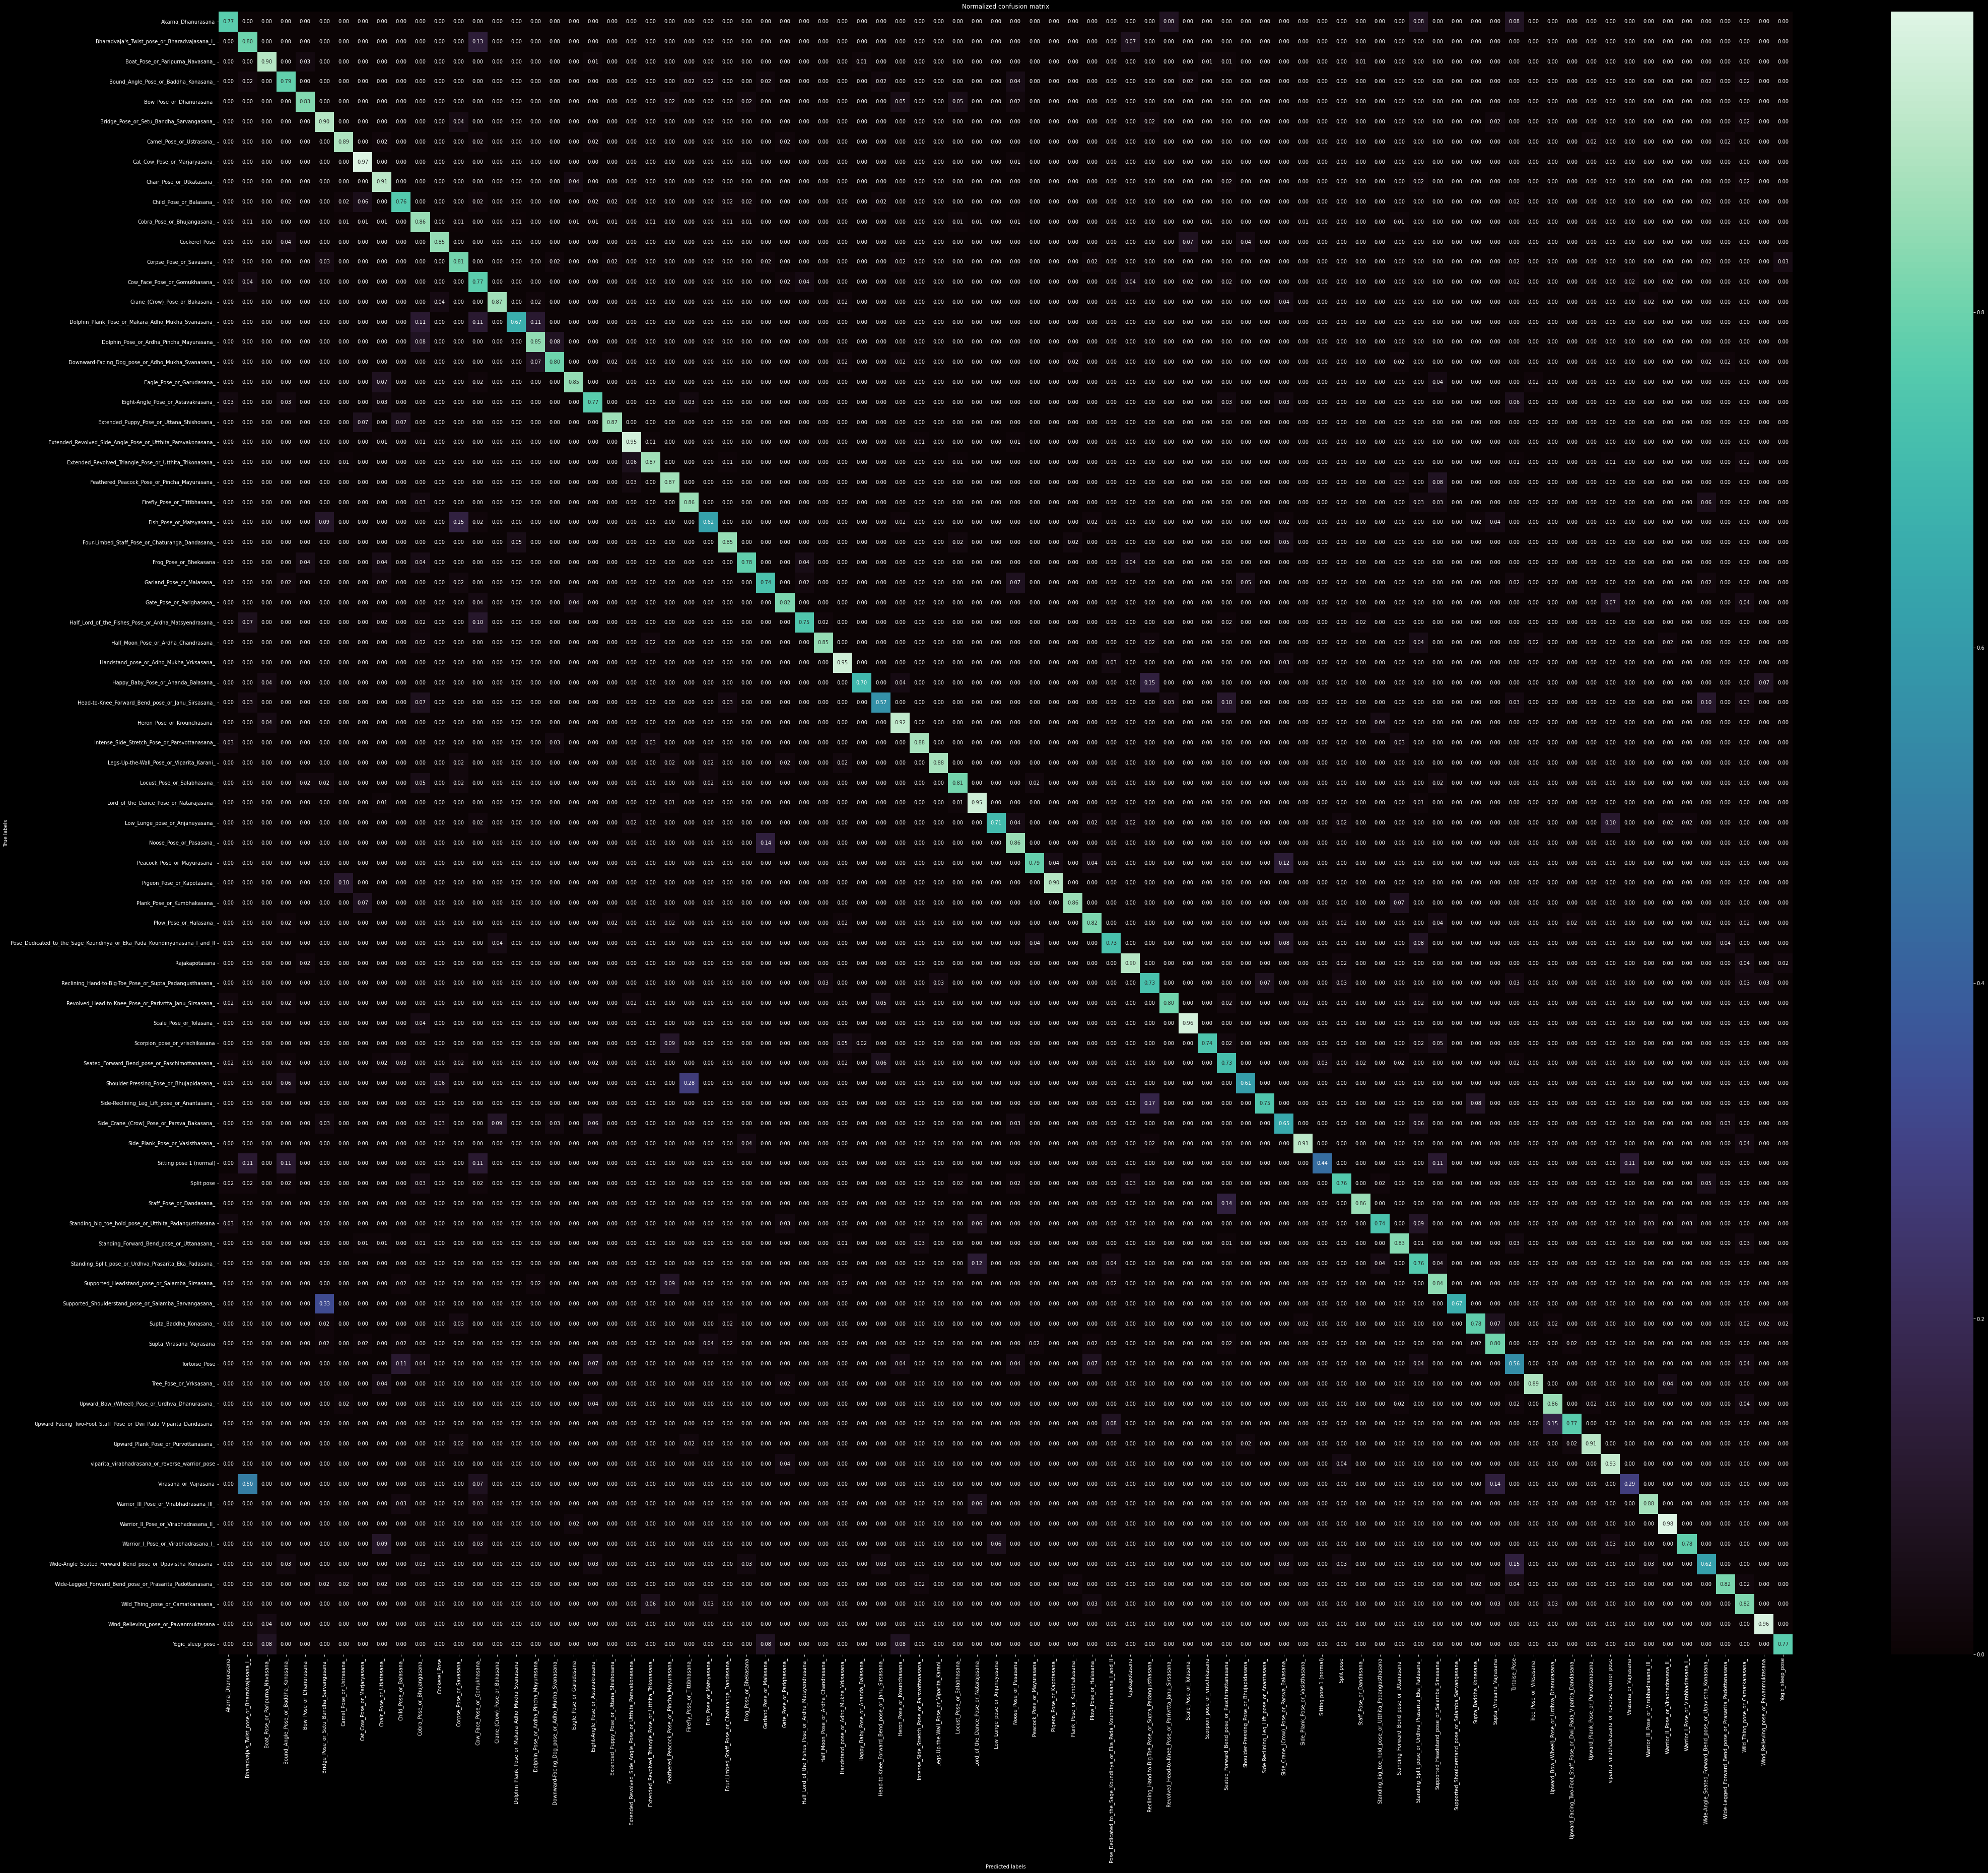

Top 5 worst cases from Confusion Matrix.

percent	true                                                                  pred
0.50	Virasana_or_Vajrasana                                                 Bharadvaja's_Twist_pose_or_Bharadvajasana_I_
0.33	Supported_Shoulderstand_pose_or_Salamba_Sarvangasana_                 Bridge_Pose_or_Setu_Bandha_Sarvangasana_
0.28	Shoulder-Pressing_Pose_or_Bhujapidasana_                              Firefly_Pose_or_Tittibhasana_
0.17	Side-Reclining_Leg_Lift_pose_or_Anantasana_                           Reclining_Hand-to-Big-Toe_Pose_or_Supta_Padangusthasana_
0.15	Upward_Facing_Two-Foot_Staff_Pose_or_Dwi_Pada_Viparita_Dandasana_     Upward_Bow_(Wheel)_Pose_or_Urdhva_Dhanurasana_
0.15	Fish_Pose_or_Matsyasana_                                              Corpse_Pose_or_Savasana_


In [83]:
predicitons = []
true_labels = []

totalVals = len(test_data)
for i in range(totalVals):
    output = model(test_data[i]['input'].to(device))
    predicitons.append(output.argmax(dim=0, keepdim=True))
    true_labels.append(test_data[i]['label'].argmax(dim=0, keepdim=True).to(device))

predicitons = [i.item() for i in predicitons]
true_labels = [i.item() for i in true_labels]

cm = get_confusion_matrix(true_labels, predicitons)
print_worst_cm(cm, 5)

In [ ]:
# Save the model parameters to a file
torch.save(model.state_dict(), 'models/fnn_parameters.pth')

# Define a new instance of the model
new_model = PoseFFNN(input_dim=69, output_dim=82)

# Load the saved model parameters into the new model
new_model.load_state_dict(torch.load('models/fnn_parameters.pth'))

In [28]:
# open the video file
video = cv2.VideoCapture('yoga.mp4')

# initialize an empty list to store the images
images = []

# loop through the video frames
while video.isOpened():
    # read the current frame
    ret, frame = video.read()
    # check if the frame was read successfully
    if ret:
        # append the frame to the images list
        images.append(frame)
    else:
        # break the loop if there are no more frames
        break

# release the video object
video.release()

# print the number of images extracted from the video
print(f"Total images extracted: {len(images)}")

Total images extracted: 4162


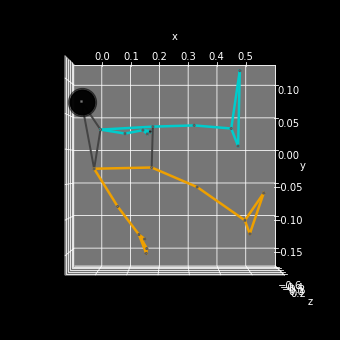

Corpse_Pose_or_Savasana_


In [85]:
for i, image in enumerate(images):
    if i % 6 == 0:
        clear_output(wait=True)
        imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = mediaPipe.process(imageRGB)
        if results.pose_landmarks:
            featureVector = center_chest(results.pose_landmarks.landmark)
            plot(featureVector)
            featureVector = torch.Tensor(featureVector.flatten())
            pred = model(featureVector.to(device)).argmax(dim=0, keepdim=True)
            print(poses[pred])
        else:
            print('bad image')